# Summarizing failure reasons
This notebook demonstrates how one can dive into summarizing error messages and failure reasones. The `_result.jsonl` files contain a column `result`, which contains a string, that in case of test failure is "failed: " and in other cases contains additionally the error message that was observed. These failures and errors can be summarized for each model as shown here.

In [1]:
import pandas as pd
import os

In [2]:
directory = "../data/"
# if you want to investigate a single model only, add its name here:
search_term = ""

# Enter the terms to search for here
common_errors = ['has no attribute', 'invalid syntax', 'is not defined', "Can't convert object", 'cannot import', 'out of range', 'unexpected keyword argument']

First we collect all results and the corresponding models from the jsonl files.

In [3]:
collection = []
for filename in os.listdir(directory):
    if search_term in filename and filename.endswith("_results.jsonl"):
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace("samples_","").replace("_results","").replace(".jsonl","")
        collection.append(df)

if len(collection) == 1:
    df = collection[0]
else:
    df = pd.concat(collection)

We then focus on the tests which failed.

In [4]:
df = df[df['passed'] == False]
df

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\n# Plan:\n# 1. Import required libraries (cv2...,Here's the completed code with a step-by-step ...,failed: OpenCV(4.9.0) D:\a\opencv-python\openc...,False,claude-3-5-sonnet-20240620
2,../test_cases/binary_skeleton.ipynb,\n# Plan:\n# 1. Import necessary libraries (sk...,Here's the completed code with a step-by-step ...,failed: Input must be a 2D numpy array of bool...,False,claude-3-5-sonnet-20240620
6,../test_cases/convolve_images.ipynb,\n# Plan:\n# 1. Check if the input images are ...,"Here's the complete code with a plan, necessar...",failed: Input image and kernel image must have...,False,claude-3-5-sonnet-20240620
12,../test_cases/deconvolve_image.ipynb,\n# Plan:\n# 1. Import required libraries (num...,"Here's the completed code with a plan, necessa...",failed: fft2() got an unexpected keyword argum...,False,claude-3-5-sonnet-20240620
13,../test_cases/detect_edges.ipynb,\n# Plan:\n# 1. Convert the image to grayscale...,"Here's the completed code with a plan, necessa...",failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,False,claude-3-5-sonnet-20240620
...,...,...,...,...,...,...
565,../test_cases/workflow_batch_process_folder_me...,\nimport os\nimport cv2 # for handling tif im...,# Plan to solve the problem step by step:\n1. ...,failed: 'label',False,phi3-3.8b-mini-instruct-4k-fp16
566,../test_cases/workflow_segmentation_counting.i...,# Step-by-step plan:\n1. Load the given `image...,# Step-by-step plan:\n1. Load the given `image...,failed: unterminated string literal (detected ...,False,phi3-3.8b-mini-instruct-4k-fp16
567,../test_cases/workflow_segmentation_measuremen...,\n# Step-by-step plan to solve the problem:\n\...,```python\n# Step-by-step plan to solve the pr...,failed: OpenCV(4.9.0) D:\a\opencv-python\openc...,False,phi3-3.8b-mini-instruct-4k-fp16
568,../test_cases/workflow_segment_measure_umap.ipynb,"\nfrom skimage import io, measure, morphology\...","```python\nfrom skimage import io, measure, mo...","failed: ""None of [Index(['Area', 'Perimeter', ...",False,phi3-3.8b-mini-instruct-4k-fp16


In [5]:
# Just some examples to get an idea
df.head(10)['result'].tolist()

["failed: OpenCV(4.9.0) D:\\a\\opencv-python\\opencv-python\\opencv\\modules\\imgproc\\src\\thresh.cpp:1555: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'\n> THRESH_OTSU mode:\n>     'src_type == CV_8UC1 || src_type == CV_16UC1'\n> where\n>     'src_type' is 4 (CV_32SC1)\n",
 'failed: Input must be a 2D numpy array of boolean type',
 'failed: Input image and kernel image must have the same dimensions',
 "failed: fft2() got an unexpected keyword argument 's'",
 "failed: OpenCV(4.9.0) d:\\a\\opencv-python\\opencv-python\\opencv\\modules\\imgproc\\src\\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x59191d0d::Set<1,-1,-1>,struct cv::impl::A0x59191d0d::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'

## Searching for common terms
First, we search the error messages for common errors as specified above.

In [6]:
# Define the function to count errors
def count_errors(group, error_list):
    counts = {error: group['result'].str.contains(error, regex=False).sum() for error in error_list}
    return pd.Series(counts)

# Apply the function to each model group
error_counts = df.groupby('model').apply(count_errors, error_list=common_errors)

# Transpose the result for the desired format: models as columns, errors as rows
error_counts = error_counts.T
error_counts

C:\Users\rober\AppData\Local\Temp\ipykernel_15380\3576577103.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_counts = df.groupby('model').apply(count_errors, error_list=common_errors)


model,claude-3-5-sonnet-20240620,claude-3-opus-20240229,codegemma-7b-instruct-fp16,codellama,codellama-70b-instruct-q4_0,command-r-plus-104b-q4_0,deepseek-coder-v2,gemini-1.5-flash-001,gemini-1.5-pro-001,gemini-pro,...,gpt-4o-2024-08-06,gpt-4o-mini-2024-07-18,llama3-70b-instruct-q4_0,llama3-70b-instruct-q8_0,llama3-8b-instruct-fp16,mistral-nemo,mixtral-8x22b-instruct-v0.1-q4_0,mixtral-8x7b-instruct-v0.1-q5_0,o1-mini-2024-09-12,phi3-3.8b-mini-instruct-4k-fp16
has no attribute,28,45,49,59,41,25,31,28,35,43,...,32,43,42,38,60,59,58,54,30,44
invalid syntax,0,0,1,58,56,167,4,1,0,0,...,0,2,6,5,10,24,3,7,0,30
is not defined,0,5,86,32,36,45,2,35,10,203,...,0,4,3,1,12,28,5,27,0,26
Can't convert object,0,1,1,13,13,0,0,0,0,3,...,0,0,0,0,0,0,6,3,0,12
cannot import,0,5,15,17,7,6,7,13,11,6,...,3,0,2,12,12,19,4,7,2,6
out of range,0,3,5,4,4,1,0,20,11,0,...,0,0,0,1,3,4,1,9,0,4
unexpected keyword argument,8,5,8,4,8,0,11,2,9,1,...,8,4,5,10,4,9,3,13,7,8


In [7]:
# reorder columns to be similar to evaluation result plots
with open("model_order.txt", 'r') as f:
    columns_in_order = f.readlines()
    columns_in_order = [c.strip() for c in columns_in_order if "reference" not in c]
columns_in_order

['claude-3-5-sonnet-20240620',
 'gpt-4o-2024-08-06',
 'o1-mini-2024-09-12',
 'gpt-4o-2024-05-13',
 'gpt-4-turbo-2024-04-09',
 'claude-3-opus-20240229',
 'gpt-4-1106-preview',
 'gemini-1.5-pro-001',
 'gpt-4o-mini-2024-07-18',
 'deepseek-coder-v2',
 'llama3-70b-instruct-q8_0',
 'llama3-70b-instruct-q4_0',
 'gpt-3.5-turbo-1106',
 'gemini-1.5-flash-001',
 'codegemma-7b-instruct-fp16',
 'mixtral-8x22b-instruct-v0.1-q4_0',
 'mixtral-8x7b-instruct-v0.1-q5_0',
 'phi3-3.8b-mini-instruct-4k-fp16',
 'codellama-70b-instruct-q4_0',
 'gemini-pro',
 'mistral-nemo',
 'llama3-8b-instruct-fp16',
 'command-r-plus-104b-q4_0',
 'codellama']

In [8]:
error_counts = error_counts[columns_in_order]
error_counts

model,claude-3-5-sonnet-20240620,gpt-4o-2024-08-06,o1-mini-2024-09-12,gpt-4o-2024-05-13,gpt-4-turbo-2024-04-09,claude-3-opus-20240229,gpt-4-1106-preview,gemini-1.5-pro-001,gpt-4o-mini-2024-07-18,deepseek-coder-v2,...,codegemma-7b-instruct-fp16,mixtral-8x22b-instruct-v0.1-q4_0,mixtral-8x7b-instruct-v0.1-q5_0,phi3-3.8b-mini-instruct-4k-fp16,codellama-70b-instruct-q4_0,gemini-pro,mistral-nemo,llama3-8b-instruct-fp16,command-r-plus-104b-q4_0,codellama
has no attribute,28,32,30,33,33,45,48,35,43,31,...,49,58,54,44,41,43,59,60,25,59
invalid syntax,0,0,0,0,0,0,1,0,2,4,...,1,3,7,30,56,0,24,10,167,58
is not defined,0,0,0,0,4,5,8,10,4,2,...,86,5,27,26,36,203,28,12,45,32
Can't convert object,0,0,0,0,1,1,3,0,0,0,...,1,6,3,12,13,3,0,0,0,13
cannot import,0,3,2,2,3,5,2,11,0,7,...,15,4,7,6,7,6,19,12,6,17
out of range,0,0,0,1,0,3,0,11,0,0,...,5,1,9,4,4,0,4,3,1,4
unexpected keyword argument,8,8,7,5,15,5,8,9,4,11,...,8,3,13,8,8,1,9,4,0,4


0.13.2


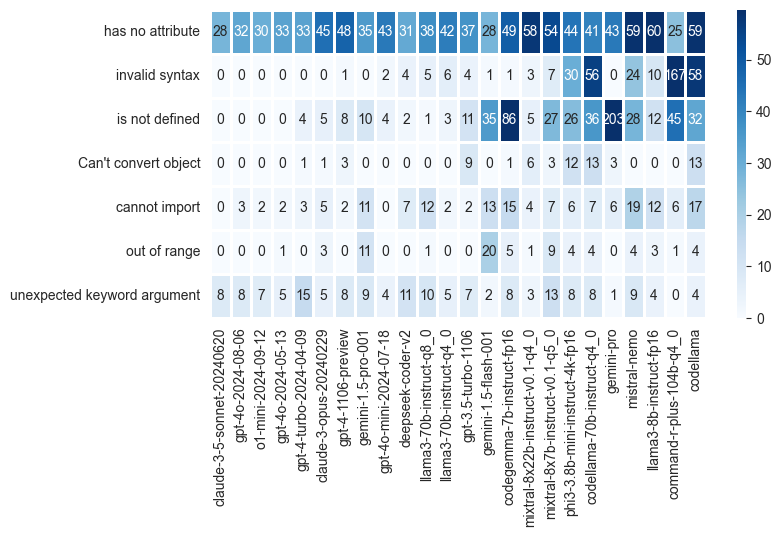

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print(sns.__version__)
sns.set_style("white")


# Separate the numerical data for plotting and the string column for y-axis labels
numerical_data = error_counts.select_dtypes(include=[np.number])

# Plotting
fig = plt.figure(figsize=(8,4))
#plot square heatmap entries
sns.heatmap(numerical_data, annot=True, linewidths=1, fmt=".0f", cbar_kws={'shrink': 1, 'aspect': 2*16}, cmap="Blues", robust=True)
plt.gca().set_xlabel('')
plt.gca().set_ylabel('')

plt.savefig("../docs/paper/error_counts_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
error_counts.columns = [f"\\rot{{{col}}}" for col in error_counts.columns]
error_counts

,\rot{claude-3-5-sonnet-20240620},\rot{gpt-4o-2024-08-06},\rot{o1-mini-2024-09-12},\rot{gpt-4o-2024-05-13},\rot{gpt-4-turbo-2024-04-09},\rot{claude-3-opus-20240229},\rot{gpt-4-1106-preview},\rot{gemini-1.5-pro-001},\rot{gpt-4o-mini-2024-07-18},\rot{deepseek-coder-v2},...,\rot{codegemma-7b-instruct-fp16},\rot{mixtral-8x22b-instruct-v0.1-q4_0},\rot{mixtral-8x7b-instruct-v0.1-q5_0},\rot{phi3-3.8b-mini-instruct-4k-fp16},\rot{codellama-70b-instruct-q4_0},\rot{gemini-pro},\rot{mistral-nemo},\rot{llama3-8b-instruct-fp16},\rot{command-r-plus-104b-q4_0},\rot{codellama}
has no attribute,28,32,30,33,33,45,48,35,43,31,...,49,58,54,44,41,43,59,60,25,59
invalid syntax,0,0,0,0,0,0,1,0,2,4,...,1,3,7,30,56,0,24,10,167,58
is not defined,0,0,0,0,4,5,8,10,4,2,...,86,5,27,26,36,203,28,12,45,32
Can't convert object,0,0,0,0,1,1,3,0,0,0,...,1,6,3,12,13,3,0,0,0,13
cannot import,0,3,2,2,3,5,2,11,0,7,...,15,4,7,6,7,6,19,12,6,17
out of range,0,0,0,1,0,3,0,11,0,0,...,5,1,9,4,4,0,4,3,1,4
unexpected keyword argument,8,8,7,5,15,5,8,9,4,11,...,8,3,13,8,8,1,9,4,0,4


Next we save the dataframe as tex to disk, so that we can include it in the manuscript.

In [11]:
# Convert DataFrame to TeX format string
tex_str = error_counts.to_latex()

# Define filename for the TeX file
tex_filename = '../docs/paper/error_counts_table.tex'

# Write the TeX format string to a file
with open(tex_filename, 'w') as tex_file:
    tex_file.write(tex_str)

## Most popular failure reasons
Furthermore, we search for the three most observed reasons for failure. These might be either error messages, or in case the result is only `failed: ` this indicated that the tests were not passed, presumably because the tested function did not return the right result.

In [12]:
# Step 1: Group the DataFrame by 'model' and get the value counts of 'result'
model_result_count = df.groupby('model')['result'].value_counts()

# Step 2: Create an empty DataFrame to store the results
model_top_results = []

# Step 3: Loop through each group to get the three most common results per model
for model, counts in model_result_count.groupby(level=0):
    # Get the top three results (note: nlargest returns the results)
    top_three = counts.nlargest(3)
    # Prepare data to append to the DataFrame
    data = {
        'Model': model,
        'Top1 Result': top_three.index.get_level_values(1)[0],
        'Top1 Count': top_three.iloc[0],
        'Top2 Result': top_three.index.get_level_values(1)[1] if len(top_three) > 1 else None,
        'Top2 Count': top_three.iloc[1] if len(top_three) > 1 else None,
        'Top3 Result': top_three.index.get_level_values(1)[2] if len(top_three) > 2 else None,
        'Top3 Count': top_three.iloc[2] if len(top_three) > 2 else None
    }
    # Append data
    model_top_results.append(data)

# Display the resulting DataFrame
most_common_errors = pd.DataFrame(model_top_results)
most_common_errors

,Model,Top1 Result,Top1 Count,Top2 Result,Top2 Count,Top3 Result,Top3 Count
0,claude-3-5-sonnet-20240620,failed:,149,failed: 'list' object has no attribute 'shape',20,failed: OpenCV(4.9.0) D:\a\opencv-python\openc...,10
1,claude-3-opus-20240229,failed:,164,failed: 'list' object has no attribute 'shape',23,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,11
2,codegemma-7b-instruct-fp16,failed:,137,failed: name 'np' is not defined,61,failed: 'list' object has no attribute 'shape',13
3,codellama,failed:,98,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,26,"failed: invalid syntax (<string>, line 4)",22
4,codellama-70b-instruct-q4_0,failed:,109,"failed: invalid syntax (<string>, line 4)",26,"failed: invalid syntax (<string>, line 5)",15
5,command-r-plus-104b-q4_0,failed:,96,"failed: invalid syntax (<string>, line 4)",73,"failed: invalid syntax (<string>, line 5)",38
6,deepseek-coder-v2,failed:,166,failed: OpenCV(4.10.0) d:\a\opencv-python\open...,16,failed: OpenCV(4.10.0) D:/a/opencv-python/open...,11
7,gemini-1.5-flash-001,failed:,166,failed: OpenCV(4.9.0) d:\a\opencv-python\openc...,37,failed: name 'np' is not defined,29
8,gemini-1.5-pro-001,failed:,151,failed: 'list' object has no attribute 'shape',26,failed: OpenCV(4.10.0) D:\a\opencv-python\open...,13
9,gemini-pro,failed: name 'np' is not defined,152,failed:,96,failed: 'list' object has no attribute 'shape',17
